<a href="https://colab.research.google.com/github/lekiho/NSR_AD/blob/main/biLSTM2021_HAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import platform
platform.platform()

'Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic'

In [ ]:
import os
import time
import copy
import tarfile

import keras
from keras import optimizers
from keras.models import Model, Sequential, load_model
from keras.layers import Input,Bidirectional ,LSTM, Dense, Activation, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
from pathlib import Path
from datetime import timedelta

import dateutil
import matplotlib.pyplot as plt
from tqdm.notebook import trange

In [ ]:
import sys
print("python_version : " + sys.version)
print("\nnumpy : " + np.__version__)
print("pandas : " + pd.__version__)
print("keras : " + keras.__version__)
print("tensorflow : " + tf.__version__)

python_version : 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

numpy : 1.21.6
pandas : 1.3.5
keras : 2.8.0
tensorflow : 2.8.2


HAI Dataset

In [ ]:
TRAIN_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab_Notebooks/HAI/data/New folder4/training").glob("*.csv")])
# VALIDATION_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab_Notebooks/HAI/data/New folder4/validation").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab_Notebooks/HAI/data/New folder4/testing").glob("*.csv")])

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
# VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)

# TRAIN_DF_RAW = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI/HAI_train_total.csv', index_col=[0])
# TEST_DF_RAW = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/GTA/data/HAI/HAI_test_total.csv', index_col=[0])

TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


In [ ]:
TIMESTAMP_FIELD = 'time'
# TIMESTAMP_FIELD = ' Timestamp'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [ ]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [ ]:
# 학습 데이터셋에서 최솟값, 최댓값 산출
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
# VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()

print(boundary_check(TRAIN_DF))
print(boundary_check(TEST_DF))
# print(boundary_check(VALIDATION_DF))

(False, False, False)
(True, True, False)


In [ ]:
def HaiDataset(timestamps, df, stride=1, attacks=None):
    ts= np.array(timestamps)
    tag_values=np.array(df,dtype=np.float32)
    valid_idxs=[]
    for L in trange(len(ts)-WINDOW_SIZE+1):
        R = L + WINDOW_SIZE - 1
        if dateutil.parser.parse(ts[R]) - dateutil.parser.parse(ts[L]) == timedelta(seconds=WINDOW_SIZE - 1):
            valid_idxs.append(L)
    valid_idxs=np.array(valid_idxs, dtype=np.int32)[::stride]
    n_idxs = len(valid_idxs)
    print("# of valid windows:", n_idxs)
    if attacks is not None:
        attacks = np.array(attacks, dtype=np.float32)
        with_attack = True
    else:
        with_attack = False
        
    
    timestamp, X, y, att = list(), list(), list(), list()
    
    if with_attack:
        for i in valid_idxs:
            last=i+WINDOW_SIZE-1
            seq_time, seq_x, seq_y, seq_attack = ts[last], tag_values[i:i+WINDOW_GIVEN], tag_values[last], attacks[last]
            timestamp.append(seq_time)
            X.append(seq_x)
            y.append(seq_y)
            att.append(seq_attack)
            
        return np.array(timestamp), np.array(X), np.array(y), np.array(att)
    else:
        for i in valid_idxs:
            last=i+WINDOW_SIZE-1
            seq_time, seq_x, seq_y = ts[last], tag_values[i:i+WINDOW_GIVEN], tag_values[last]
            timestamp.append(seq_time)
            X.append(seq_x)
            y.append(seq_y)
        return np.array(timestamp), np.array(X), np.array(y)

In [ ]:
## 35seq, 10seq, 50seq 학습 모델 생성
# 기본 모델은 35seq
# 10seq, 50seq는 추후 사용

WINDOW_SIZE= 10
WINDOW_GIVEN = WINDOW_SIZE - 1

ts, X_train, y_train = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
# ts, X_valid, y_valid, attack = HaiDataset(VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD])
ts, X_test, y_test, attack = HaiDataset(TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=TEST_DF_RAW[ATTACK_FIELD])

aux_train=[]
for i in range(len(X_train)):
    aux_train.append(X_train[i][0])
aux_train=np.array(aux_train)

aux_valid=[]
for i in range(len(X_test)):
    aux_valid.append(X_test[i][0])
aux_valid=np.array(aux_valid)

  0%|          | 0/921594 [00:00<?, ?it/s]

# of valid windows: 921576


  0%|          | 0/401996 [00:00<?, ?it/s]

# of valid windows: 401960


In [ ]:
# 딥러닝 학습 및 추론에는 Keras를 사용
# 과적합 방지 적용
ModelName = '/content/drive/MyDrive/Colab_Notebooks/biLSTM/LSTM__HAI2103_10seq_test.h5'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(ModelName, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
## LSTM Model define

# 3층 양방향 LSTM 사용
# Hidden cell = 100
# Dropout 미사용
# Skip connection 사용

n_features = TRAIN_DF.shape[1]

inputs=Input(shape=(WINDOW_GIVEN , n_features))
first=Bidirectional(LSTM(100, return_sequences=True))(inputs)
second=Bidirectional(LSTM(100, return_sequences=True))(first)
third=Bidirectional(LSTM(100))(second)

lstm_out=Dense(n_features)(third)

aux_input = Input(shape=(n_features,), name='aux_input')
outputs = keras.layers.add([lstm_out, aux_input])
model=Model(inputs=[inputs, aux_input], outputs=outputs)

model.compile(loss='mean_squared_error', optimizer='Adam')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 9, 79)]      0           []                               
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 9, 200)      144000      ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 9, 200)      240800      ['bidirectional_3[0][0]']        
 )                                                                                                
                                                                                            

Epoch 1/32
7200/7200 [==============================] - ETA: 0s - loss: 7.3162e-04
Epoch 1: val_loss improved from inf to 0.01147, saving model to /content/drive/MyDrive/Colab_Notebooks/biLSTM/LSTM__HAI2103_10seq_test.h5
7200/7200 [==============================] - 127s 17ms/step - loss: 7.3162e-04 - val_loss: 0.0115
Epoch 2/32
7197/7200 [============================>.] - ETA: 0s - loss: 3.9411e-04
Epoch 2: val_loss improved from 0.01147 to 0.01136, saving model to /content/drive/MyDrive/Colab_Notebooks/biLSTM/LSTM__HAI2103_10seq_test.h5
7200/7200 [==============================] - 117s 16ms/step - loss: 3.9410e-04 - val_loss: 0.0114
Epoch 3/32
7197/7200 [============================>.] - ETA: 0s - loss: 3.5819e-04
Epoch 3: val_loss improved from 0.01136 to 0.01135, saving model to /content/drive/MyDrive/Colab_Notebooks/biLSTM/LSTM__HAI2103_10seq_test.h5
7200/7200 [==============================] - 118s 16ms/step - loss: 3.5816e-04 - val_loss: 0.0113
Epoch 4/32
7197/7200 [=============

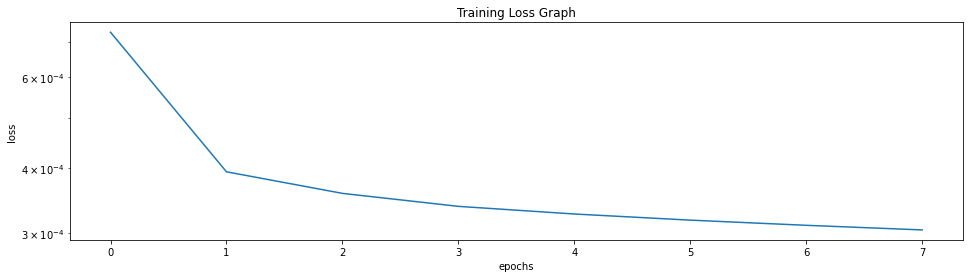

In [ ]:
hist=model.fit([X_train, aux_train], y_train, batch_size=128, epochs=32, shuffle=True, 
               callbacks=[es, mc], validation_data=([X_test,aux_valid],y_test))

plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(hist.history['loss'])
plt.show()

In [ ]:
model.save(ModelName)

print("--- Complete ---")

--- Complete ---


In [ ]:
## model load

WINDOW_SIZE= 10
WINDOW_GIVEN = WINDOW_SIZE - 1

model = load_model('/content/drive/MyDrive/Colab_Notebooks/biLSTM/LSTM__HAI2103_10seq_test.h5')
print(ModelName + " load")

# 예측값 산출
y_pred=model.predict([X_test,aux_valid])

/content/drive/MyDrive/Colab_Notebooks/biLSTM/LSTM__HAI2103_10seq_test.h5 load


In [ ]:
# 검증 데이터셋 전체 시간대에 해당하는 모든 필드의 (예측값 - 실제값)
tmp=[]
for i in range(len(y_pred)):
    tmp.append(abs(y_test[i]-y_pred[i]))
    
    
ANOMALY_SCORE=np.mean(tmp,axis=1)

In [ ]:
# 가중치를 조절한 Moving Average 사용

wMA10=[]
for idx in range(len(ANOMALY_SCORE)):
    if idx >= 10:
        wMA10.append((ANOMALY_SCORE[idx-10:idx].mean()*9+ANOMALY_SCORE[idx])/10)
    else:
        wMA10.append(ANOMALY_SCORE[idx])

wMA10=np.array(wMA10)
print(wMA10.shape)

(401960,)


In [ ]:
## anomaly score -> 라벨 생성
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

## 라벨 대상 / 빈 공간 0 채우기
# 날짜가 바뀌면서 시간이 연속되지 않는 구간은 부득이하게 정상으로 처리
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current >  ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [ ]:
ATTACK_LABELS = put_labels(np.array(TEST_DF_RAW[ATTACK_FIELD]), threshold=0.5)
print(len(ATTACK_LABELS), sum(ATTACK_LABELS))

402005 8947


In [ ]:
THRESHOLD = 0.0121
# THRESHOLD = 0.0175

LABELS_MA = put_labels(wMA10, THRESHOLD)
print(len(LABELS_MA), sum(LABELS_MA))

401960 8958.0


In [ ]:
FINAL_LABELS_MA = fill_blank(ts, LABELS_MA, np.array(TEST_DF_RAW[TIMESTAMP_FIELD]))
print(len(FINAL_LABELS_MA), sum(FINAL_LABELS_MA))

402005 8958


In [ ]:
# anomaly score가 미세한 차이로 threshold를 넘나드는 경우, 짧은 시간동안 오탐/미탐이 발생
# 탐지된 공격의 시간을 기준으로 정상과 anomaly를 판단하는 정책 적용

def Gray_Area(attacks):
    n_attacks = copy.deepcopy(attacks)
    for k in range(3):
        start = []   # start point
        finish = []  # finish point
        com = 0         # 처음에만 적용
        count = 0       # 연속된 수 카운트
        c = []          # 카운트 저장
        
        for i in range(1, len(n_attacks)):   # 라벨 파악
            if com == 0:                         # 처음에만 적용
                start.append(i)
                count = count + 1
                com = 1
            elif n_attacks[i - 1] != n_attacks[i]:  # 변화 발생
                finish.append(i - 1)
                c.append(count)
                count = 0
                start.append(i)
                count = count + 1
            else:                                # 카운트 (변화x)
                count = count + 1

        finish.append(len(n_attacks) - 1)
        c.append(finish[len(finish) - 1] - start[len(start) - 1] + 1)
        
        if k == 0:
            for i in range(0, len(start)):
                if c[i] < 100:
                    s = start[i]
                    f = finish[i] + 1

                    if n_attacks[start[i] - 1] == 1:
                        g1 = [1 for i in range(c[i])]
                        n_attacks[s:f] = g1
            
        elif k == 1:
            for i in range(0, len(start)):
                if c[i] < 10:
                    s = start[i]
                    f = finish[i] + 1

                    if n_attacks[start[i] - 1] == 0:
                        g0 = [0 for i in range(c[i])]
                        n_attacks[s:f] = g0
    
    return n_attacks

In [ ]:
# NewGray 적용

gray_LABELS=Gray_Area(FINAL_LABELS_MA)
print(gray_LABELS.shape, sum(gray_LABELS))

(402005,) 10226


In [ ]:
pro_LABELS = list(gray_LABELS)

PRO_WINDOW_SIZE = 30

for i in range(PRO_WINDOW_SIZE, len(pro_LABELS)):
    if 1 <= sum(pro_LABELS[i-PRO_WINDOW_SIZE:i]):
        pro_LABELS[i-PRO_WINDOW_SIZE] = 1
    else:
        pro_LABELS[i-PRO_WINDOW_SIZE] = 0
        
print(sum(pro_LABELS))

12952


In [ ]:
pd.DataFrame(ATTACK_LABELS).value_counts()

0    393058
1      8947
dtype: int64

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/GTA
from TaPR_pkg import etapr
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=pro_LABELS)
print("TEST DATASET / THRESHOLD: " + str(THRESHOLD) + " / wMA10")
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, eTaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")

/content/drive/MyDrive/Colab_Notebooks/GTA
TEST DATASET / THRESHOLD: 0.0121 / wMA10
F1: 0.717 (TaP: 0.602, eTaR: 0.888)
# of detected anomalies: 46


In [ ]:
# pd.DataFrame(pro_LABELS).to_csv('/content/drive/MyDrive/Colab_Notebooks/biLSTM/output/biLSTM_HAI2103_35_THR0175_pred.csv')

In [ ]:
## anomaly score 대상 / 빈 공간 Na
def score_check_ts(pred, check_ts, path):
    temp_score = pd.read_csv(path)
    temp_score.index = temp_score[TIMESTAMP_FIELD]

    ColumnName = 'predict'
    temp_score.loc[check_ts, ColumnName] = pred
    
    return temp_score[ColumnName]

In [ ]:
# 공격 종료지점을 판단하기 위해 같은 방식으로 10seq, 50seq 라벨 생성
def finish_pred_val(WINDOW_SIZE, THRESHOLD):
    WINDOW_GIVEN = WINDOW_SIZE - 1

    ModelName = '/content/drive/MyDrive/Colab_Notebooks/biLSTM/LSTM_' + str(WINDOW_SIZE) + 'seq.h5'
    model = load_model(ModelName)
    print(ModelName + " load")
    
    ts, X_valid, y_valid, attack = HaiDataset(TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=TEST_DF_RAW[ATTACK_FIELD])

    aux_valid=[]
    for i in range(len(X_valid)):
        aux_valid.append(X_valid[i][0])
    aux_valid=np.array(aux_valid)

    y_pred=model.predict([X_valid,aux_valid])

    tmp=[]
    for i in range(len(y_pred)):
        tmp.append(abs(y_valid[i]-y_pred[i]))
    ANOMALY_SCORE=np.mean(tmp,axis=1)

    wMA10=[]
    for idx in range(len(ANOMALY_SCORE)):
        if idx >= 10:
            wMA10.append((ANOMALY_SCORE[idx-10:idx].mean()*9+ANOMALY_SCORE[idx])/10)
        else:
            wMA10.append(ANOMALY_SCORE[idx])

    wMA10=np.array(wMA10)
    LABELS_MA = put_labels(wMA10, THRESHOLD)
    FINAL_LABELS_MA = fill_blank(ts, LABELS_MA, np.array(TEST_DF_RAW[TIMESTAMP_FIELD]))
    gray_LABELS=Gray_Area(FINAL_LABELS_MA)
    
    return list(gray_LABELS)

In [ ]:
PRED1 = list(pro_LABELS)

WINDOW_SIZE = 10
WINDOW_GIVEN = WINDOW_SIZE - 1
PRED2 = finish_pred_val(WINDOW_SIZE, 0.0115)

WINDOW_SIZE = 50
WINDOW_GIVEN = WINDOW_SIZE - 1
PRED3 = finish_pred_val(WINDOW_SIZE, 0.0125)

# val_seq60_MA = score_check_ts(wMA10, ts, './Dataset/sample_validation.csv')
# FINAL_score = np.array(val_seq60_MA.fillna(0))

OSError: ignored